In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
train_X = pd.read_csv("train_X.csv").set_index('mid')
train_X_normalized = pd.read_csv("train_X_normalized.csv").set_index('mid')
train_y = pd.read_csv('train_y.csv').set_index('mid')['radiant_win']

In [3]:
def draw(results, param, title, limit=None):
    if limit is not None:
        results = results[results['mean_test_score'] > limit]
        
    plt.rcParams["figure.figsize"]=10,5
    
    mean = results['mean_test_score']
    std = results['std_test_score']
    xasix = list(results['param_'+ param])
    
    plt.grid()
    plt.fill_between(xasix, mean - std, mean + std, alpha=0.1, color="r")
    plt.plot(xasix, mean, 'o-', color="r",
                 label="Cross-validation score")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.show()
    
def print_max(results, param, limit = None):
    params = results['param_' + param]
    mean = results['mean_test_score']
    std = results['std_test_score']
        
    if limit is None:
        idx = np.argmax(mean)
        return f'{param}: {params[idx]}, score: {mean[idx]}, std: {std[idx]}'
    
    return results[results['mean_test_score'] > limit]

При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это могло повлиять на качество, давайте посмотрим на значения самих признаков.

**(1 балл) Задание 4.** Посмотрите на значения признаков по gold и lh. В чем заключается особенность данных? На какие из рассматриваемых алгоритмов это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

**Ответ:**
gold и lh - это вещественные признаки, которые могут изменяться в разных границах. lh - количество последних ударов исчисляется десятками, gold - исчисляется сотнями, но оба они строго не отрицательны. Поэтому классификаторы, которые завязаны на масштаб признака, по разному учитывают в классификации значения признаков lh и gold.

Например, алгоритм SGG и KNN чувствительны и после масштабирования каждого признака в отдельности, точность классификации должна улучшиться.

А для Decision Tree и Random Forest точность классификации не изменилась, т.к. границы вычисляются по каждому признаку независимо.

Однако прежде чем делать окончательные выводы, посмотрим, насколько признаки кореллированы

In [6]:
train_data_test = train_X.copy()
train_data_test['gold_to_gold'] = train_X['gold_sum_radiant'] / train_X['gold_sum_dire']
train_data_test['lh_to_lh'] = train_X['lh_sum_radiant'] / train_X['lh_sum_dire']
train_data_test['gold_to_lh'] = train_data_test['gold_to_gold'] / train_data_test['lh_to_lh']
train_data_test = train_data_test.dropna()

In [7]:
np.corrcoef(train_data_test['lh_to_lh'], train_data_test['gold_to_gold'])

array([[1.        , 0.80026889],
       [0.80026889, 1.        ]])

**0.8** - очень высокий уровень кореляции, поэтому улучшения алгоритмов может и не случиться. Проверим это на практике

Масштабирование признаков можно выполнить, например, одним из следующих способов:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).


**(1 балл) Задание 5.** Отмасштабируйте все вещественные признаки одним из указанных выше способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Изменилось ли качество некоторых алгоритмов и почему?

Для решения будем использовать нормализованные данные, полученные в первом задании

## KNeighborsClassifier

Нормализуем данные и проведем повторный эксперимент. Данные так же заранее вычислены на кластере.

Построим график и найдем наибольшее значение

In [18]:
results = pd.read_csv('knn_normalized.csv')

In [19]:
draw(results, 'n_neighbors', 'KNN', 0.775)

In [20]:
print('NOT normalized: n_neighbors: 928, score: 0.7781616542343285, std: 0.006406089030173061')
print_max(results, 'n_neighbors')

'n_neighbors: 1433, score: 0.7780723471302387, std: 0.005913105587200918'

Оптимальное значение **1433**, причём само значение хуже чем для ненормализованных данных, что действительно могло случиться из-за высокой коррелированности признаков.
Так же для нормализованных данных существенно выше количество соседей, поэтому в дальнейшем будем обучаться на ненормализованных данных.

## DecisionTree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

max_depth = list(range(1, 20))
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, {'max_depth': max_depth}, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(train_X_normalized, train_y)
results_decision_tree = clf.cv_results_
;

''

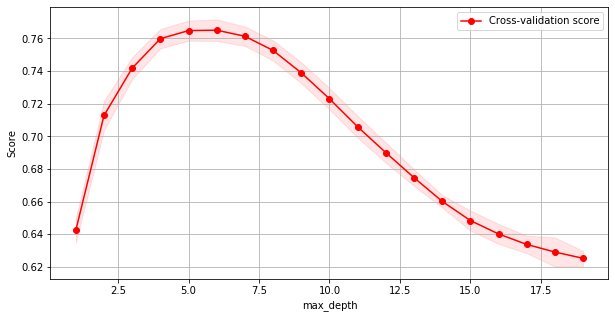

In [10]:
draw(results_decision_tree, 'max_depth', 'DecisionTree')

In [11]:
print('NOT normalized: max_depth: 6, score: 0.7650241305795809, std: 0.0065013579144704145')
print_max(results_decision_tree, 'max_depth')

NOT normalized: max_depth: 6, score: 0.7650241305795809, std: 0.0065013579144704145


'max_depth: 6, score: 0.7650920822949897, std: 0.006577562106250977'

Практическая проверка подтверждает, нормализация признаков существенно не сказалась на точности модели

## SGD Linear Classifier

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
sgd = SGDClassifier()
clf = GridSearchCV(sgd, {'loss': loss}, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(train_X_normalized, train_y)
results_sgd = clf.cv_results_
;

''

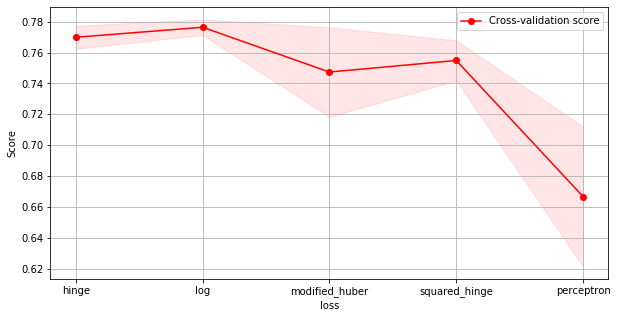

In [13]:
draw(results_sgd, 'loss', 'SGD Linear Classifier')

In [16]:
print('NOT normalized: loss: log, score: 0.780795529898613, std: 0.0066623699509413235')
print_max(results_sgd, 'loss')

NOT normalized: loss: log, score: 0.780795529898613, std: 0.0066623699509413235


'loss: log, score: 0.7763704813575174, std: 0.0050584590356124864'

Для данной метрики скор ухудшился. Сказалась высокая коррелированность признаков

## RandomForest

Проведем аналогичные вычисления для случайных деревьев только на нормализованных данных

In [22]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators = 3
columns = ['param_n_estimators', 'mean_test_score', 'std_test_score']
kf = KFold(n_splits=5)

X_train = []
X_test = []
y_train = []
y_test = []
rfc_bulk = []
score = []

for train_index, test_index in kf.split(train_X_normalized):
    X_train.append(train_X.iloc[train_index, :])
    X_test.append(train_X.iloc[test_index, :])
    y_train.append(train_y.iloc[train_index])
    y_test.append(list(train_y.iloc[test_index]))

for i in range(5):
    current_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rfc_bulk.append(current_model)
    
    current_model.fit(X_train[i], y_train[i])
    proba = current_model.predict_proba(X_test[i])[:, 1]
    current_score = roc_auc_score(y_test[i], proba)
    score.append(current_score)
    
mean_test_score = np.mean(score)
std = np.std(score)

In [23]:
estimators_score = pd.DataFrame([[n_estimators, mean_test_score, std]], columns=columns).set_index('param_n_estimators')

In [24]:
for j in range(n_estimators - 1, 1, -1):
#     print(j)
    newtree_score = []
    for i in range(5):
        current_model = rfc_bulk[i]
        current_model.estimators_.pop()

        proba = current_model.predict_proba(X_test[i])[:, 1]
        current_score = roc_auc_score(y_test[i], proba)
        newtree_score.append(current_score)

    mean_test_score = np.mean(newtree_score)
    std = np.std(newtree_score)
    estimators_score = estimators_score.append(pd.DataFrame([[j, mean_test_score, std]], columns=columns).set_index('param_n_estimators'))
    

In [27]:
results = pd.read_csv("rf_normalized.csv")

In [28]:
draw(results, 'n_estimators', 'Random Forest', 0.76)

In [29]:
print('NOT normalized: n_estimators: 4501, score: 0.7743684689543656, std: 0.007230779189479635')
print_max(results, 'n_estimators')

NOT normalized: n_estimators: 4501, score: 0.7743684689543656, std: 0.007230779189479635


'n_estimators: 4222, score: 0.7745815412663025, std: 0.007241163658176283'

Экспериментально подтвердили, что улучшения модели при нормализации не просиходит

### Выводы

Действительно, для DecisionTree и RandomForest ожидаемо не получили улучшения модели.
Для KNN - так же не удалось улучшить из-за высокой корреляции признаков.
Единственная модель которая была улучшена на текущем скоре, это SDG.